Number of distinct linear regions: 20


/var/folders/w_/_4hnpxr91r78y8gdhv58zlrm0000gn/T/ipykernel_2945/2233972374.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('tab20', 20),


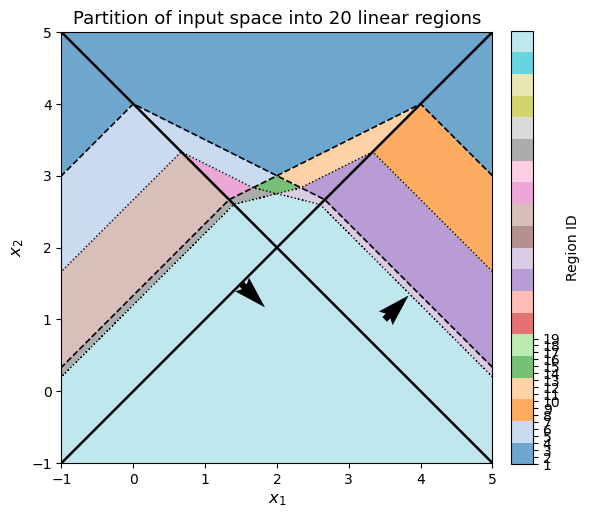

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1.  ReLU units (exactly as in the paper) --------------------------
# ------------------------------------------------------------------
def ha(x1, x2):
    return np.maximum(0.0, -x1 + x2)

def hb(x1, x2):
    return np.maximum(0.0,  x1 + x2 - 4)

def hc(x1, x2):
    a, b = ha(x1, x2), hb(x1, x2)
    return np.maximum(0.0, -a - 3*b + 4)

def hd(x1, x2):
    a, b = ha(x1, x2), hb(x1, x2)
    return np.maximum(0.0, -3*a - b + 4)

def he(x1, x2):
    c, d = hc(x1, x2), hd(x1, x2)
    return np.maximum(0.0,  c + 3*d - 4)

def hf(x1, x2):
    c, d = hc(x1, x2), hd(x1, x2)
    return np.maximum(0.0, 3*c +   d - 4)

# ------------------------------------------------------------------
# 2.  Dense grid over the input square -----------------------------
# ------------------------------------------------------------------
grid = np.linspace(-1, 5, 801)             # 800×800 ~ 6.4 e5 points
X, Y = np.meshgrid(grid, grid)

# Compute every unit on the whole grid (fully vectorised & fast)
HA = np.maximum(0, -X + Y)
HB = np.maximum(0,  X + Y - 4)
HC = np.maximum(0, -HA - 3*HB + 4)
HD = np.maximum(0, -3*HA -  HB + 4)
HE = np.maximum(0,  HC + 3*HD - 4)
HF = np.maximum(0, 3*HC +   HD - 4)

# Turn the 6‑bit on/off pattern into an integer ID (0‑63) per point
region_id = (
      (HA > 0).astype(np.uint8)        # bit 0
    | (HB > 0).astype(np.uint8) << 1   # bit 1
    | (HC > 0).astype(np.uint8) << 2   # bit 2
    | (HD > 0).astype(np.uint8) << 3   # bit 3
    | (HE > 0).astype(np.uint8) << 4   # bit 4
    | (HF > 0).astype(np.uint8) << 5   # bit 5
)

n_regions = len(np.unique(region_id))
print(f"Number of distinct linear regions: {n_regions}")   # → 20

# ------------------------------------------------------------------
# 3.  Plot ----------------------------------------------------------
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 6))

# colour each pixel by its region ID (tab20 → 20 qualitatively distinct colours)
im = ax.imshow(region_id,
               origin='lower',
               extent=[-1, 5, -1, 5],
               cmap=plt.cm.get_cmap('tab20', 20),
               interpolation='nearest',
               alpha=0.65)

# First‑layer hyperplanes (solid)
ax.contour(X, Y, -X + Y,     levels=[0], colors='k', linewidths=1.8)
ax.contour(X, Y,  X + Y - 4, levels=[0], colors='k', linewidths=1.8)

# Second‑layer hyperplanes in input space (dashed)
ax.contour(X, Y, -HA - 3*HB + 4, levels=[0], colors='k',
           linewidths=1.2, linestyles='--')
ax.contour(X, Y, -3*HA - HB + 4, levels=[0],  colors='k',
           linewidths=1.2, linestyles='--')

# Third‑layer hyperplanes in input space (dotted)
ax.contour(X, Y,  HC + 3*HD - 4, levels=[0], colors='k',
           linewidths=1.0, linestyles=':')
ax.contour(X, Y, 3*HC +   HD - 4, levels=[0], colors='k',
           linewidths=1.0, linestyles=':')

# Arrow tips show the “active” side for the first‑layer lines
arrow_kwargs = dict(angles='xy', scale_units='xy', scale=3, width=0.015, color='k')
ax.quiver(1.5, 1.5,  1, -1, **arrow_kwargs)   # ha: (-x1+x2>0)
ax.quiver(3.5, 1.0,  1,  1, **arrow_kwargs)   # hb: (x1+x2-4>0)

ax.set_xlim(-1, 5)
ax.set_ylim(-1, 5)
ax.set_aspect('equal')
ax.set_xlabel(r'$x_1$', fontsize=12)
ax.set_ylabel(r'$x_2$', fontsize=12)
ax.set_title('Partition of input space into 20 linear regions', fontsize=13)

cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04,
                    ticks=range(0, 20))
cbar.set_label('Region ID')

plt.tight_layout()
plt.show()


Regions on [-1,5]² : 20
Regions on [-1,1]² : 20


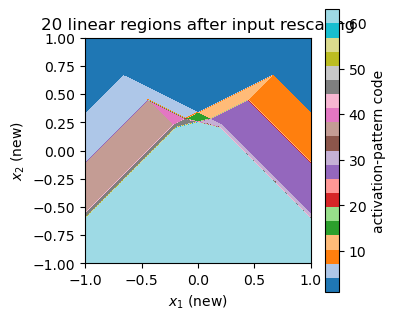

In [7]:
# Figure‑2 network: two inputs → 3 hidden layers with 2 ReLUs each
import numpy as np
import matplotlib.pyplot as plt

# ---------- 1. forward pass ----------
def fig2_forward(x1: np.ndarray, x2: np.ndarray):
    """
    x1, x2: 1‑D NumPy arrays of the same length
    returns: (N, 6) array of ReLU outputs [ha, hb, hc, hd, he, hf]
    """
    ha = np.maximum(0.0, -x1 + x2)
    hb = np.maximum(0.0,  x1 + x2 - 4)
    hc = np.maximum(0.0, -ha - 3*hb + 4)
    hd = np.maximum(0.0, -3*ha -  hb + 4)
    he = np.maximum(0.0,  hc + 3*hd - 4)
    hf = np.maximum(0.0, 3*hc +  hd - 4)
    return np.stack([ha, hb, hc, hd, he, hf], axis=1)

# ---------- 2. helper to count distinct activation patterns ----------
def count_regions(xs, ys, forward_fn):
    """
    xs, ys: meshgrid-created arrays of shape (H,W)
    forward_fn: function that maps 1‑D x1,x2 to (N,6) outputs
    returns: number of unique binary activation patterns
    """
    outs = forward_fn(xs.ravel(), ys.ravel())           # (N,6)
    patterns = (outs > 0).astype(np.uint8)              # 1 = active ReLU
    # Convert each 6‑bit pattern to an int so we can use a Python set
    codes = np.packbits(patterns, axis=1, bitorder='little')[:,0]
    return len(set(codes))

# ---------- 3. ORIGINAL domain  [-1,5]² ----------
grid_N = 601                         # ~0.01 spacing
gx, gy = np.meshgrid(np.linspace(-1, 5, grid_N),
                     np.linspace(-1, 5, grid_N))

n_regions_original = count_regions(gx, gy, fig2_forward)
print(f"Regions on [-1,5]² : {n_regions_original}")     # 20 ✅

# ---------- 4. RESCALED domain  [-1,1]² ----------
# Affine map sending [-1,1] → [-1,5]  (scale 3, shift +2):
#   x_old = 3 * x_new + 2
def rescaled_forward(x1_new, x2_new):
    x1_old = 3 * x1_new + 2
    x2_old = 3 * x2_new + 2
    return fig2_forward(x1_old, x2_old)

gx2, gy2 = np.meshgrid(np.linspace(-1, 1, grid_N),
                       np.linspace(-1, 1, grid_N))

n_regions_rescaled = count_regions(gx2, gy2, rescaled_forward)
print(f"Regions on [-1,1]² : {n_regions_rescaled}")     # 20 ✅

# ---------- 5. (optional) quick visualisation of activation pattern IDs ----------
codes = np.packbits((rescaled_forward(gx2.ravel(), gy2.ravel()) > 0)
                    .astype(np.uint8),
                    axis=1, bitorder='little')[:,0]
plt.figure(figsize=(4,4))
plt.imshow(codes.reshape(gx2.shape), extent=[-1,1,-1,1], origin='lower', cmap='tab20')
plt.title("20 linear regions after input rescaling")
plt.xlabel(r"$x_1$ (new)")
plt.ylabel(r"$x_2$ (new)")
plt.colorbar(label="activation‑pattern code", shrink=0.8)
plt.tight_layout()
plt.show()


In [6]:
import numpy as np

# ----- 1.  Define the six ReLU units -----
def ha(x1, x2):
    return np.maximum(0.0, -x1 + x2)

def hb(x1, x2):
    return np.maximum(0.0,  x1 + x2 - 4)

def hc(x1, x2):
    a, b = ha(x1, x2), hb(x1, x2)
    return np.maximum(0.0, -a - 3*b + 4)

def hd(x1, x2):
    a, b = ha(x1, x2), hb(x1, x2)
    return np.maximum(0.0, -3*a - b + 4)

def he(x1, x2):
    c, d = hc(x1, x2), hd(x1, x2)
    return np.maximum(0.0,  c + 3*d - 4)

def hf(x1, x2):
    c, d = hc(x1, x2), hd(x1, x2)
    return np.maximum(0.0, 3*c +   d - 4)

# Convenience: active/inactive (1/0) sign pattern for a single point
def sign_pattern(x1, x2):
    vals = (ha(x1,x2), hb(x1,x2), hc(x1,x2),
            hd(x1,x2), he(x1,x2), hf(x1,x2))
    return tuple(int(v > 0) for v in vals)

# ----- 2–4.  Sample the input space and count regions -----
grid = np.linspace(-1, 5, 401)        # 400×400 = 1.6 e5 points – dense enough
regions = {sign_pattern(x, y)         # set of unique patterns
           for x in grid
           for y in grid}

print(f"Number of distinct linear regions: {len(regions)}")


Number of distinct linear regions: 20


Width 3, depth 2:  found  15  linear regions


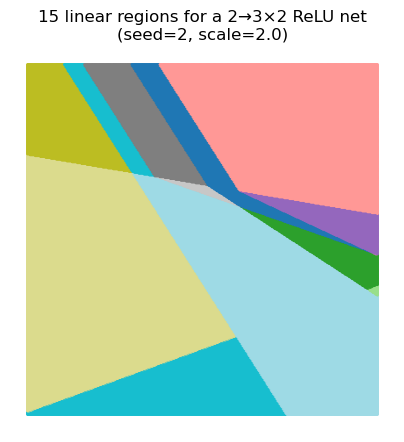

In [5]:
# neural_regions_demo.py
# ------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt


# ------------ network builder ------------------------------------------------
def build_net(width=3, depth=4, *, seed=2, scale=2.0):
    """
    Returns lists [W₁, …, W_L], [b₁, …, b_L]
    where each Wₗ has shape (width, in_dim)   and   bₗ has shape (width,)
    """
    rng = np.random.default_rng(seed)
    Ws, bs = [], []
    in_dim = 2                                     # (x, y)
    for _ in range(depth):
        Ws.append(rng.normal(scale=scale, size=(width, in_dim)))
        bs.append(rng.normal(scale=scale, size=width))
        in_dim = width
    return Ws, bs


# ------------ forward pass that records sign pattern -------------------------
def forward_signs(X, Ws, bs):
    signs, H = [], X
    for W, b in zip(Ws, bs):
        Z = H @ W.T + b
        signs.append((Z > 0).astype(np.uint8))     # 1 = active, 0 = inactive
        H = np.maximum(Z, 0)
    return np.concatenate(signs, axis=1)


# ------------ utility to count / colour regions ------------------------------
def mesh(grid=400, lo=-1.0, hi=1.0):
    xs = np.linspace(lo, hi, grid)
    xx, yy = np.meshgrid(xs, xs)
    return np.stack([xx.ravel(), yy.ravel()], axis=1), xx, yy


def region_ids(sign_matrix):
    """Compress each binary sign‑vector into an integer label."""
    bit_weights = 1 << np.arange(sign_matrix.shape[1], dtype=np.uint64)
    return (sign_matrix * bit_weights).sum(axis=1)


# ------------ put it all together -------------------------------------------
def plot_regions(width=3, depth=4, seed=2, scale=2.0, grid=400):
    Ws, bs = build_net(width, depth, seed=seed, scale=scale)
    pts, xx, yy = mesh(grid)
    signs = forward_signs(pts, Ws, bs)
    ids   = region_ids(signs)
    n_regions = np.unique(ids).size
    print(f"Width {width}, depth {depth}:  found  {n_regions}  linear regions")

    plt.figure(figsize=(5, 5))
    plt.scatter(pts[:, 0], pts[:, 1], c=ids, s=1, cmap="tab20")
    plt.gca().set_aspect("equal")
    plt.title(f"{n_regions} linear regions for a 2→{width}×{depth} ReLU net\n"
              f"(seed={seed}, scale={scale})")
    plt.axis("off")
    plt.show()


# ------------ example run ----------------------------------------------------
if __name__ == "__main__":
    plot_regions(width=3, depth=2, seed=2, scale=2.0)


In [2]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [6]:
W1 = [[ 1, 0],        # u₁ = [x]₊
      [ 0, 1]]        # u₂ = [y]₊
b1 = [0, 0]
# h1 = ReLU(W1 x + b1)      # 4 quadrants → first‑quadrant “fold”

# δ = 1.0                             # side length of the triangle
W2 = [[ 2, -2],                     # t₁(u₁)
      [-2,  2]]                     # t₂(u₂)
b2 = [-1.0, -1.0]
# h2 = ReLU(W2 h1 + b2)

W3 = [[ 2,  2],
      [ 2, -2]]
b3 = [-1/2, -1/2]


In [ ]:
W1 = np.array([[ 1,  1],
               [-1,  1]])
b1 = np.zeros(2)

# Layer 2 : translate & rotate again
W2 = np.array([[ 1, -1],
               [ 1,  1]])
b2 = np.array([ 0.5, -0.5])

# Layer 3 : another translate/rotate
W3 = np.array([[ 1,  1],
               [-1,  1]])
b3 = np.array([ 0.25, -0.75])

In [13]:
# Layer ℓ (ℓ = 1, 2, …)
Wℓ = np.array([[ 2,  0],        # splits x at   k/2^ℓ
               [-2,  0],        # splits x at 1-k/2^ℓ
               [ 0,  1]])       # carries y forward unchanged
bℓ = np.array([-(2*k-1)/2**ℓ,   # k toggles 1,2,1,2,...
               (2*k-1)/2**ℓ-1,
               0])


NameError: name 'k' is not defined

Text(0.5, 1.0, '16 linear regions with a 2×2×2×2 ReLU net')

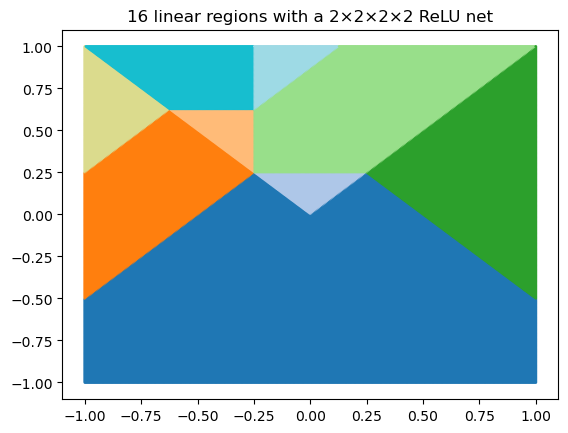

In [12]:

# grid of points in [-1,1]²
xx, yy = np.meshgrid(np.linspace(-1,1,400), np.linspace(-1,1,400))
pts = np.stack([xx.ravel(), yy.ravel()], axis=1)

# forward pass & region id = full sign pattern
def forward(X, Ws, bs):
    signs = []
    H = X
    for W, b in zip(Ws, bs):
        Z = H @ W.T + b
        signs.append((Z > 0).astype(int))
        H = np.maximum(Z, 0)
    return np.concatenate(signs, axis=1)

pattern = forward(pts, [W1, W2, W3], [b1, b2, b3])
region_id = (pattern * (1 << np.arange(pattern.shape[1]))).sum(axis=1)

plt.scatter(pts[:,0], pts[:,1], c=region_id, s=1, cmap='tab20')
plt.title("16 linear regions with a 2×2×2×2 ReLU net")


Text(0.5, 1.0, '16 linear regions with a 2×2×2×2 ReLU net')

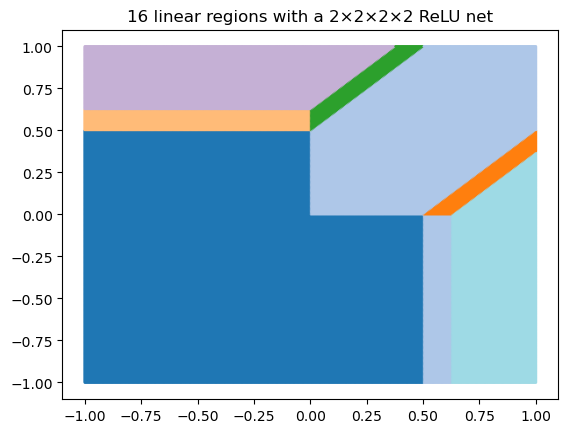